In [56]:
include("quadrotor_script.jl")
using Plots

N = 30
#dimConstraintsU = 3
#dimSecondOrderConeConstraintsU = 1
dimLinearConstraintsU = 9
dimSecondOrderConeConstraintsU = 0
MAX_ITERATIONS_NB = 100

model = Quadrotor()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp), copy(Up)

SCPproblem = GuSTOProblem(model, N, dimLinearConstraintsU, dimSecondOrderConeConstraintsU, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
epsilon, rho0, rho1, 
beta_succ, beta_fail, gamma_fail, 
convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

1.0

In [48]:
X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(B_success &&
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    println("-----------")
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # GuSTO Logic
    if it > 0
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                    B_success = false
                end
            end

        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
    else
        X = copy(X_sol)
        U = copy(U_sol)
    end

    push!(X_all, copy(X))
    push!(U_all, copy(U))       
    
    it += 1
    
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println(" ")
end


-----------
Iteration 0
-----------
Parameters:
omega=1.0
delta=100.0
metric=73.07580667374579
 
-----------
Iteration 1
-----------
Accept solution.
Parameters:
omega=1.0
delta=100.0
metric=24.181761999638052
 
-----------
Iteration 2
-----------
Accept solution.
Parameters:
omega=1.0
delta=100.0
metric=9.87910767086679
 
-----------
Iteration 3
-----------
Accept solution.
Parameters:
omega=1.0
delta=100.0
metric=2.406382017179661
 


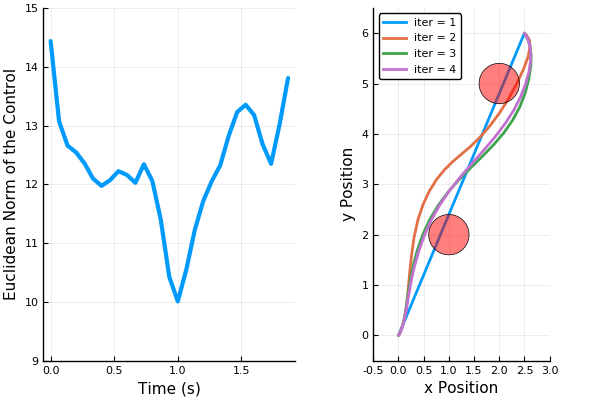

In [65]:
timeSpan = zeros(N-1)
normU = zeros(N-1)
normU[1] = sqrt(U_all[end][1,1]^2 + U_all[end][2,1]^2 + U_all[end][3,1]^2)
for i = 1:N-2
    timeSpan[i+1] = timeSpan[i] + 2.0/N
    normU[i+1] = sqrt(U_all[end][1,i+1]^2 + U_all[end][2,i+1]^2 + U_all[end][3,i+1]^2)
end
p1 = plot(timeSpan,normU,ylims=(9,15),linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Control")

p2 = plot_solutions(SCPproblem, model, X_all[1:end-1], U_all[1:end-1]; x_shooting_all=x_shooting_all)

plot(p1,p2,layout=(1,2))